# 1. Подготовка к работе

In [1]:
# Подгружаем библиотеки

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

from scipy import stats

%matplotlib inline

In [2]:
# Подготавливаем общие настройки для графиков

sns.set(
    rc={
        "figure.figsize": (18, 8),
        "axes.titlesize": 22,
        "axes.labelsize": 18,
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
        "legend.fontsize": 16,
        'legend.handlelength': 3,
        'legend.title_fontsize': 16
    }
)

sns.set_style("whitegrid")
sns.set_palette("RdGy", 4)

# 2. Загрузка данных

**dating_data.csv** - выгрузка логов взаимодействия пользователей друг с другом. Для каждой пары пользователей указано, из какой они группы АБ-теста и случился ли у них мэтч.

In [3]:
# Считываем данные
path_to_file = 'dating_data.csv'
dating_df = pd.read_csv(path_to_file)
dating_df.head()

,user_id_1,user_id_2,group,is_match
0,79,91,1,1
1,716,353,1,1
2,423,677,0,0
3,658,165,1,1
4,969,155,0,1


In [4]:
# Посмотрим размер данных
dating_df.shape

(14514, 4)

In [5]:
# Посмотрим тип переменных
dating_df.dtypes

user_id_1    int64
user_id_2    int64
group        int64
is_match     int64
dtype: object

In [6]:
# Проверим, что нет пропущенных значений и дубликатов
print('Количество пустых ячеек в датафрейме:', dating_df.isna().sum().sum())
print('Количество дубликатов:', dating_df.duplicated().sum())

Количество пустых ячеек в датафрейме: 0
Количество дубликатов: 0


In [7]:
# Посмотрим количество уникальных значений
dating_df.nunique()

user_id_1    1000
user_id_2    1000
group           2
is_match        2
dtype: int64

### Создадим таблицу пользователей

In [8]:
# Получим таблицу с действиями пользователей из обеих групп
user_1_df = dating_df[['user_id_1', 'group', 'is_match']].rename(columns={'user_id_1': 'user_id'})
user_2_df = dating_df[['user_id_2', 'group', 'is_match']].rename(columns={'user_id_2': 'user_id'})
users_df = pd.concat([user_1_df, user_2_df])
users_df.head()

,user_id,group,is_match
0,79,1,1
1,716,1,1
2,423,0,0
3,658,1,1
4,969,0,1


In [9]:
# Посмотрим размер данных
dating_df.shape

(14514, 4)

# 3. Выбор метрик

Для проверки работы нового алгоритма для поиска наиболее подходящих анкет был проведен АБ-тест. Все пользователи были разделены на две группы. Пользователи в группе с номером 0 пользовались приложением со старым алгоритмом. Все пользователи в группе 1 пользовались приложением с новым алгоритмом для поиска анкет.

Наша задача – оценить, правда ли, что новый алгоритм улучшил качество сервиса. Для этого выберем метрики, которые отвечают за качество сервиса, и статистически сравним эти метрики в двух группах.

Для нашего приложения важно, как часто пользователи им пользуются: просматривают анкеты, мэтчатся, как успешно проходит подбор анкет. 

Посмотрим следующие метрики (считаем, что период наблюдения был одинаков для обеих групп).

___

**Love Rate (Уровень привлекательности)** — количество лайков (мэтчей) в пересчете на размер аудитории (в нашем случае измеряется в парах пользователей).  

$$ Love\ Rate = {Количество\ лайков  \over{Количество\ пользователей}} \times 100\% = {Количество\ мэтчей  \over{Количество\ пар\ пользователей}} \times 100\%
$$ 
____


**Match Frequency (Частота мэтчей)** — эта метрика показывает, как часто у пользователя происходит мэтч.

$$ Частота\ мэтчей = {Количество\ мэтчей \over{Количество\ уникальных\ пользователей}}
$$ 

___

**View Frequency (Частота просмотра анкет)** — эта метрика показывает, как много пользователь просматривает анкет.

$$ View\ Frequency = {Количество\ просмотренных\ анкет \over{Количество\ уникальных\ пользователей}}
$$ 

___

**Like Dislike Rate (Отношение лайков к дизлайкам)** — полное количество лайков на количество дизлайков.

$$ Like\ Dislike\ Rate= {Количество\ лайков \over{Количество\ дизлайков}}
$$ 

# 4. Статистическая проверка результатов АБ-теста

In [10]:
# Найдем все нужные метрики, которые были перечислены выше

df = users_df \
    .groupby(['group'], as_index=False) \
    .agg({'user_id': 'nunique', 'is_match': ['sum', 'count']})
df.columns = ['group', 'users_count', 'matches_count', 'views_count']
df['love_rate'] = round(df.matches_count / df.views_count * 100, 1)
df['match_frequency'] = df.matches_count / df.users_count
df['view_frequency'] = df.views_count / df.users_count
df['like_dislike_rate'] = df.matches_count / (df.views_count - df.matches_count)
df.head()

,group,users_count,matches_count,views_count,love_rate,match_frequency,view_frequency,like_dislike_rate
0,0,501,1868,9584,19.5,3.728543,19.129741,0.242094
1,1,499,7818,19444,40.2,15.667335,38.965932,0.672458


In [11]:
# Посмотрим разницу величин в двух группах
difference = df.diff(axis=0).drop('group', axis=1).drop(0, axis=0)
difference

,users_count,matches_count,views_count,love_rate,match_frequency,view_frequency,like_dislike_rate
1,-2.0,5950.0,9860.0,20.7,11.938792,19.836191,0.430364


Видим, что несмотря на то, что пользователей в тестовой группе меньше, все показатели выросли.  
Однако нам предстоит узнать, статзначимы ли эти изменения или они обусловлены, например, дисперсией показателей.  

### Выбор статистических тестов

Теперь нам нужно определиться со статистическими тестами.

**Love Rate:**  
Мы имеем две категориальные переменные: группы - 0 и 1 (со старым алгоритмом и новым), мэтч - 0 и 1 (не было и был), поэтому для исследования будем использовать критерий хи-квадрат. Он подходит для анализа таблицы сопряженности любого размера, где значения ожидаемых и наблюдаемых частот в каждой ячейке больше 10. 

В остальных метриках уже фигурируют количественные переменные. Групп у нас всего 2, поэтому использовать дисперсионный анализ мы не будем. Посмотрим на требования к проведению тестов.  

Требования к проведению <b><span style='color:#ec8f68'>**t-теста (t-критерий Стьюдента)**</span>:

- Дисперсии внутри групп должны быть примерно одинаковы (требование гомогенности дисперсий).
- Необходимо, чтобы выборочные средние имели нормальное распределение. При маленьких выборках это означает требование нормальности исходных значений. Выбросы могут оказать значительное влияние на результаты t-теста. На практике t-тест может быть использован для сравнения средних и при ненормальном распределении, особенно на больших выборках и, если в данных нет заметных выбросов. В нашем случае выборки большие, поэтому нужно посмотреть только выбросы.

Однако в случае гетероскедастичности дисперсий может быть применен **<b><span style='color:#ec8f68'>t-критерий Уэлча</span>**, который является модификацией t-критерия Стьюдента и не требует равенства дисперсий. Требование о нормальном распределении сохраняется.


**<b><span style='color:#ec8f68'>Непараметрический U-критерий Манна-Уитни</span>** не столь чувствителен к наличию выбросов по сравнению с t-тестом.
Так же мы можем использовать **<b><span style='color:#ec8f68'>бутстрап</span>**. Строго говоря, нам ничего не мешает применить его для всех наших метрик, потому что ему не страшны ненормальность распределения и гетероскедастичность дисперсий. Однако на практике бутстрап может быть слишком ресурозатратным, поэтому при возможности применим более простой и быстрый метод.

In [12]:
# Создадим таблицу по пользователям

users = users_df \
    .groupby(['user_id', 'group'], as_index=False) \
    .agg({'is_match': ['sum', 'count']})
users.columns = ['user_id', 'group', 'matches_count', 'views_count']
users['like_dislike_rate'] = users.matches_count / (users.views_count - users.matches_count)
users.head()

,user_id,group,matches_count,views_count,like_dislike_rate
0,1,1,16,37,0.761905
1,2,1,16,39,0.695652
2,3,1,8,25,0.470588
3,4,0,3,17,0.214286
4,5,1,18,34,1.125000


In [13]:
# Разделим по группам
group_0 = users.query('group == 0')
group_1 = users.query('group == 1')

Для начала проведем проверку равенства дисперсий по критерию Левина.  
Гипотеза $H_0$: дисперсии равны  
Гипотеза $H_1$: дисперсии различны

In [14]:
print(f'''
Проверка распределений на равенство дисперсий (требование гомогенности дисперсий) 

Распределение количества мэтчей по группам:
p-value = {stats.levene(group_0.matches_count, group_1.matches_count)[1]}

Распределение количества просмотров по группам:
p-value = {stats.levene(group_0.views_count, group_1.views_count)[1]}

Распределение количества лайков к количеству дизлайков по группам:
p-value = {stats.levene(group_0.like_dislike_rate, group_1.like_dislike_rate)[1]}''')


Проверка распределений на равенство дисперсий (требование гомогенности дисперсий) 

Распределение количества мэтчей по группам:
p-value = 1.5179102391131175e-28

Распределение количества просмотров по группам:
p-value = 1.8829191577883398e-05

Распределение количества лайков к количеству дизлайков по группам:
p-value = 3.6424618730727393e-16


Значение p-value у всех тестов меньше нашего уровня значимости 0.05. Таким образом, в этих случаях мы отвергаем нулевую гипотезу и заключаем, что среди групп **дисперсии различны**, поэтому будем использовать t-критерий Уэлча.  
Так как выборки у нас достаточно большие t-тест должен дать приблизительно точный результат, несмотря на ненормальность распределения.

Проведем t-тесты.  
Гипотеза $H_0$: средние равны  
Гипотеза $H_1$: средние различны 

In [15]:
stats.ttest_ind(group_0.matches_count, group_1.matches_count, equal_var=False)

Ttest_indResult(statistic=-61.60792790329727, pvalue=7.010294561635124e-295)

In [16]:
stats.ttest_ind(group_0.views_count, group_1.views_count, equal_var=False)

Ttest_indResult(statistic=-62.81020734004636, pvalue=0.0)

In [17]:
stats.ttest_ind(group_0.like_dislike_rate, group_1.like_dislike_rate, equal_var=False)

Ttest_indResult(statistic=-33.86520379366676, pvalue=1.4656305006407533e-156)

Во всех случаях значение p-value очень мало (< 0.5), следовательно, мы отвергаем нулевую гипотезу и делаем вывод, что средние в группах статзначимо различаются.  
**Вывод: t-критерий Уэлча показал, что все средние статзначимо изменились.**

## Love Rate

Как уже отмечалось, будем использовать критерий хи-квадрат.

In [18]:
# Создадим таблицу сопряженности
contingency_df = pd.crosstab(dating_df.group, dating_df.is_match)
contingency_df

is_match,0,1
group,,
0,3858,934
1,5813,3909


In [19]:
# Создадим нормированную таблицу сопряженности, чтобы узнать долю пар, у которых был мэтч, в каждой группе
norm_contingency_df = pd.crosstab(dating_df.group, dating_df.is_match, normalize='index')
norm_contingency_df

is_match,0,1
group,,
0,0.805092,0.194908
1,0.597922,0.402078


Видим, что доля пар, у которых был мэтч, (уровень привлекательности анкет) с введением нового алгоритма для поиска наиболее подходящих анкет увеличился более чем в 2 раза, однако пока что это еще ни о чем не говорит. 

Проанализируем таблицу сопряженности. Мы хотим проверить, зависит ли доля пар, у которых произошел мэтч, (уровень привлекательности анкет) от группы.  

Гипотеза $H_{0}$: распределение не зависит от группы.  
Гипотеза $H_{1}$: распределение зависит от группы.

In [20]:
# Критерий хи-квадрат
statistic, pvalue, dof, expected_freq = stats.chi2_contingency(contingency_df)
print(f'''
Хи-квадрат = {statistic}
p-value = {pvalue}
Количество степеней свободы = {dof}
Ожидаемые наблюдения:
{expected_freq}
''')


Хи-квадрат = 618.6889141576198
p-value = 1.4418299163662586e-136
Количество степеней свободы = 1
Ожидаемые наблюдения:
[[3193.01584677 1598.98415323]
 [6477.98415323 3244.01584677]]



Полученное значение не укладывается в 99-процентный доверительный интервал для данного распределения (значение p-value очень мало), следовательно, можно сделать вывод, что распределение пар, у которых был мэтч (уровень привлекательности анкет) по группам статзначимо различается.  
Приведем полученное ранее распределение пар по группам.

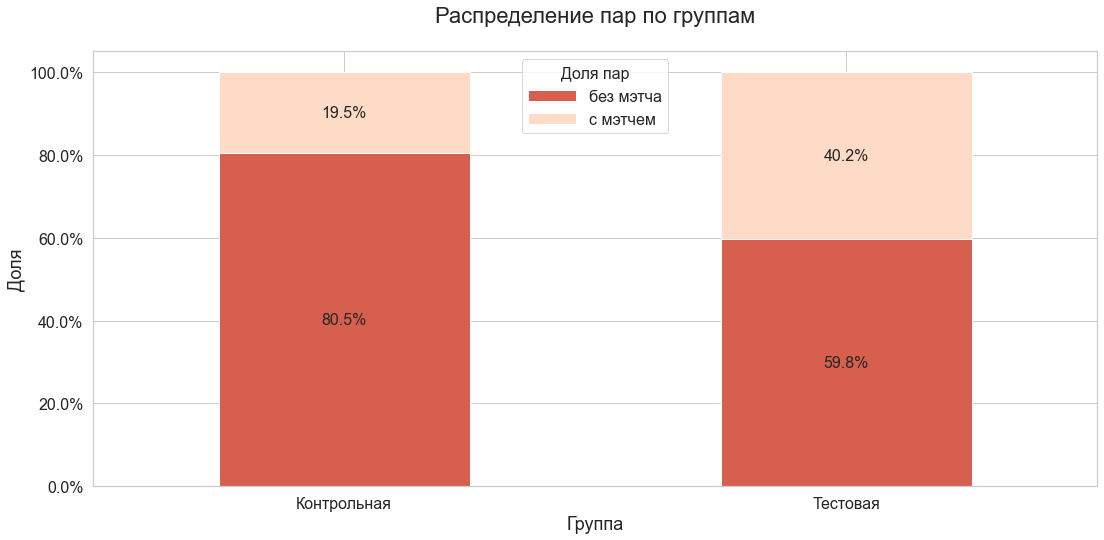

In [21]:
# Строим диаграмму

ax = norm_contingency_df.plot(kind="bar", stacked=True, rot=0)
ax.yaxis.set_major_locator(mticker.FixedLocator(ax.get_yticks()))
ax.set_yticklabels(['{:.1%}'.format(x) for x in ax.get_yticks()])
ax.set_xticklabels(['Контрольная', 'Тестовая'])
ax.legend(['без мэтча', 'с мэтчем'], title='Доля пар', loc='upper center')
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x+width/2, y+height/2, '{:.1%}'.format(height),
            horizontalalignment='center', verticalalignment='center',fontsize=16)
plt.xlabel('Группа')
plt.ylabel('Доля')
plt.title('Распределение пар по группам\n')
plt.show()

Из таблицы, формулы и диаграммы выше следует:  
Контрольная группа (со старым алгоритмом): Love Rate = 19.5%  
Тестовая группа (с новым алгоритмом): Love Rate = 40.2%

**Вывод: хи-критерий показал, что уровень привлекательности (Love Rate) анкет статзначимо увеличился с введением нового алгоритма для поиска наиболее подходящих анкет, из чего следует то, что стоит включить новую систему поиска анкет на всех пользователей.**

# 5. Вывод

Все статтесты показали статзначимые увеличения показателей: 
- Уровень привлекательности анкет
- Частота мэтчей
- Частота просмотра анкет
- Отношение лайков к дизлайкам  

**Вывод: новый алгоритм для поиска наиболее подходящих анкет принес пользу приложению и его пользователям.**